### Objective: 

Summarize the total population (or other social metric) in proximity to exposed coastline, to answer a question like,  
#### "In each subregion, how many people live within 1km of highly exposed coastline?"

### Data Needs:

1) Rasters representing population or other metric of interest  
2) CV model point outputs that have already had the coastal_exposure score categorized (e.g. 'high', 'med', 'low')
and optionally assigned each point to subregion within the AOI.  
3) Polyline representing the coastline - should be derived from the land polygon used as CV input  

### The Problem:

CV points, which are offshore, often do not directly overlap with population rasters. 
Even after snapping points to the coastline, many points still do not overlap rasters.
Buffering the points to make them overlap the raster is not ideal because point buffers overlap one another,
and a 'high risk' buffer may overlap a 'low risk' buffer, assigning the nearby population to both categories.
This is especially a problem if CV points are at a higher spatial resolution than the population raster, 
or if the coastline is very complicated and points are not arranged in a nice linear pattern.


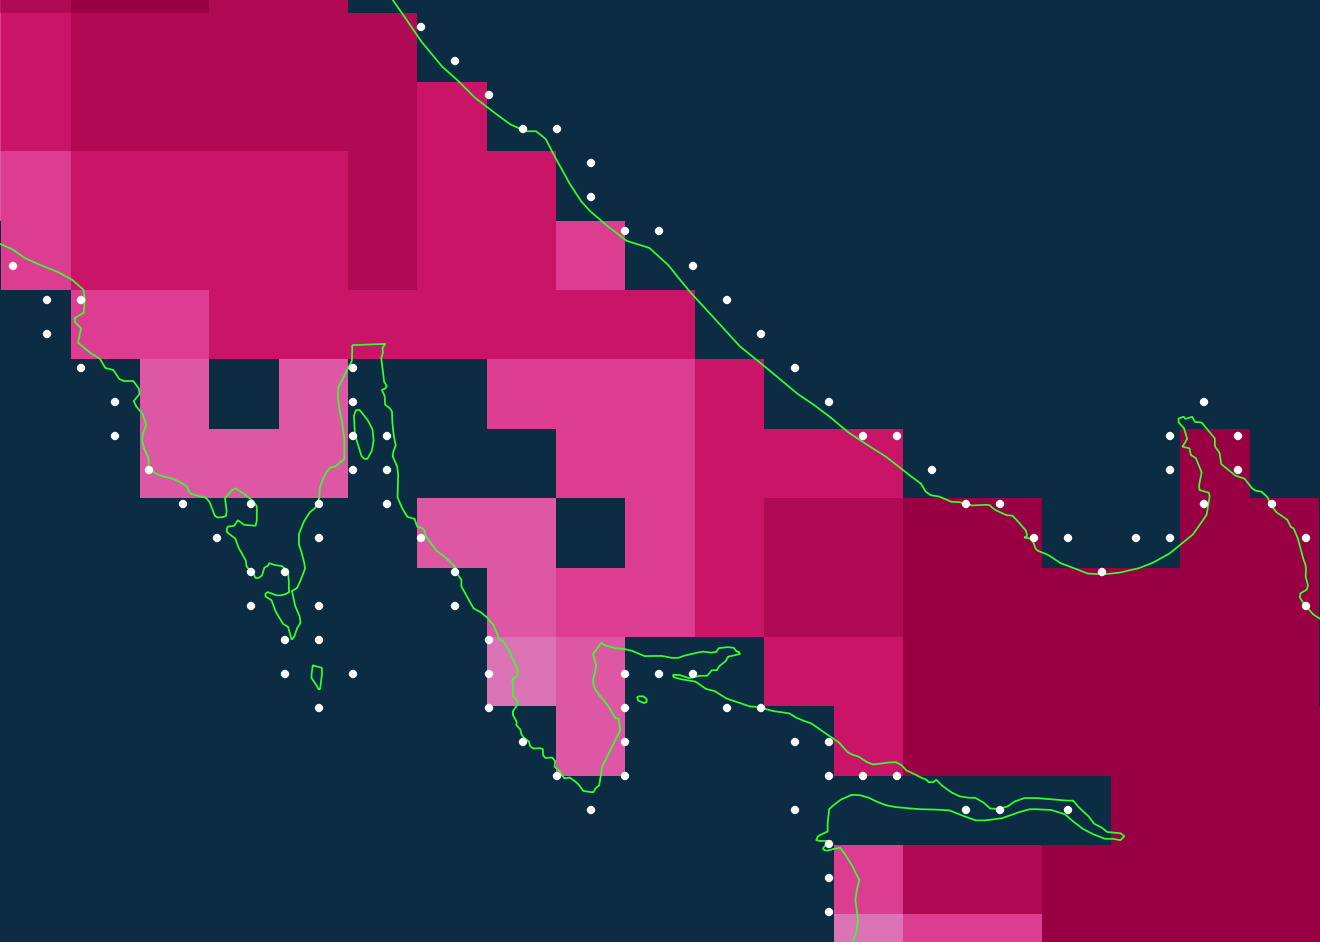

In [1]:
from IPython.display import Image
Image("./data/cv_points_population.png")

### Solution:

Make voronoi polygons from points.  
Each point is represented by a polygon that does not overlap with any other polygons.  
Use zonal stats to summarize raster values in these polygons.

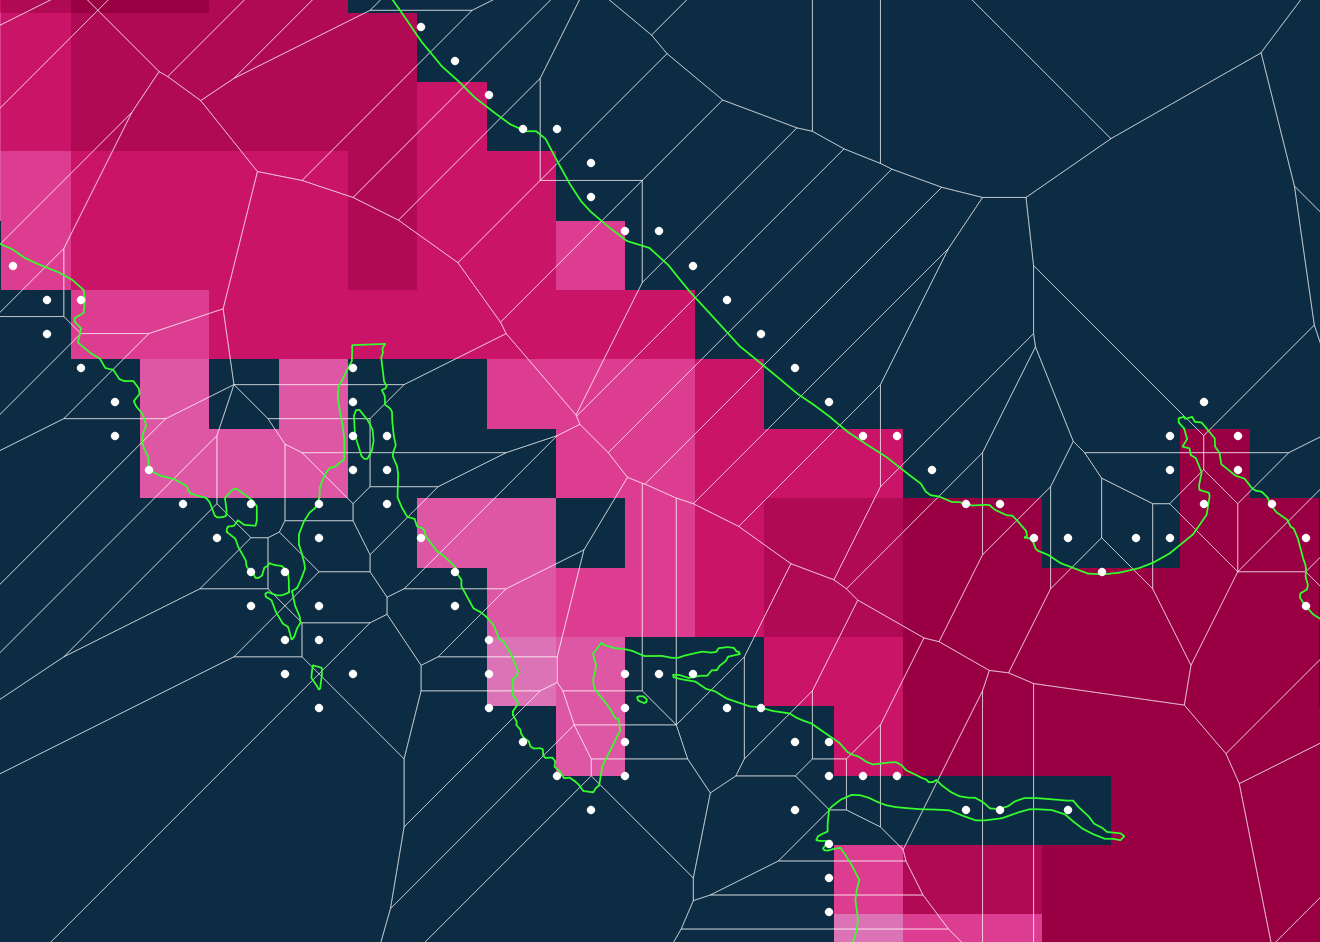

In [2]:
Image("./data/cv_points_voronoi.png")

In [3]:
import shapely
from shapely.geometry import LineString, MultiPoint, Point
from scipy.spatial import Voronoi
import pandas as pd
import numpy as np
import geopandas as gpd
# import pygeoprocessing.geoprocessing as pgp
import rasterstats as rs

### Make Voronoi polygons from CV points - for aggregating population rasters

In [4]:
dat = pd.read_csv('data/coastal_exposure.csv')

In [5]:
points = dat[['x', 'y']]

In [6]:
pts = np.array(points)

In [7]:
# voronoi polys from just the cv shore points yielded some missing polygons around the exterior,
# related to where the 'infinite points' were/weren't placed.
# workaround is to make a big ole hull around points, buffer it generously,
# then add the vertices of the hull to the point set, then create voronoi
convex_hull = MultiPoint([Point(i) for i in pts]).convex_hull.buffer(10000)
x, y = convex_hull.exterior.coords.xy
pts = np.concatenate((pts, np.array(zip(x,y))))

In [8]:
# borrowed from top answer
# https://stackoverflow.com/questions/27548363/from-voronoi-tessellation-to-shapely-polygons

vor = Voronoi(pts)

lines = [
    shapely.geometry.LineString(vor.vertices[line])
    for line in vor.ridge_vertices
    if -1 not in line
]

In [9]:
polys = list(shapely.ops.polygonize(lines))

In [10]:
len(polys) == len(points)

True

In [11]:
geopolys = gpd.GeoSeries(polys)

In [12]:
# geolines = gpd.GeoSeries(lines)

In [13]:
# get a crs
crs = gpd.read_file('./data/coastal_exposure.shp').crs
geopolys.crs = crs
# geolines.crs = crs

In [14]:
geopolys.to_file('./output/vor_polys.shp')
# geolines.to_file('../scratch/vor_lines.shp')

### Spatial Join exposure results to voronoi polygons

In [15]:
# voronoi polygons
geopolys = gpd.read_file('./output/vor_polys.shp')

In [16]:
# exposure results that have been post-processed 
# to assign exposure category ('high', 'med', 'low') and
# subregion (in this case island group) to each point
# these groups used later to group_by and summarize results

# these points happen to have data from two different scenarios
exp_pts = gpd.read_file('./data/cv_2scenarios_byisland_category.shp')

In [17]:
# subsetting one scenario at a time...and joining point attributes to voronoi polygons
vor_exp_allhab = gpd.sjoin(geopolys, exp_pts[exp_pts.variable == 'ce_allhab'], how='inner', op='contains')
len(vor_exp_allhab) == len(exp_pts[exp_pts.variable == 'ce_allhab'])

True

In [18]:
vor_exp_nompa = gpd.sjoin(geopolys, exp_pts[exp_pts.variable == 'ce_nompa'], how='inner', op='contains')
len(vor_exp_nompa) == len(exp_pts[exp_pts.variable == 'ce_nompa'])

True

In [19]:
vor_exp_allhab.to_file('./output/cv_poly_allhab_byisland_category.shp')

In [20]:
vor_exp_nompa.to_file('./output/cv_poly_nompa_byisland_category.shp')

### Zonal Stats for population metrics

In [21]:
# mask the population rasters with a buffered coastline,
# using gdalwarp -cutline, or similar
# this is faster than clipping the voronoi polygons by the buffered coastline,
# but either way ensures only coastal population areas are included in zonal stats.

# to make the buffered coastline, 
# better to extract the coastline from the land polygon rather than use the geomorphology input
# it's possible the geomorph line could be missing parts of coastline where CV places shore points

# coastline = gpd.read_file("../../cv/cv-fromjess/Bahamas_regionalCV_Inputs/Bahamas_Geomorphology_Final.shp")
# coast_1km = coastline.buffer(1000)
# unioned = coast_1km.unary_union
# outdf = coast_1km.iloc[0:1]
# coast_1km_union = gpd.GeoDataFrame(outdf, crs=coast_1km.crs, geometry=gpd.GeoSeries(unioned))
# coast_1km_union.to_file('../scratch/coast_1km_buffer.shp')

! gdalwarp -cutline ./data/coast_1km_buffer.shp ./data/pop_int2.tif ./output/coastal_pop.tif

Creating output file that is 1313P x 1389L.
Processing input file ./data/pop_int2.tif.
Using internal nodata values (e.g. -32768) for image ./data/pop_int2.tif.
Copying nodata values from source ./data/pop_int2.tif to destination ./output/coastal_pop.tif.
0...10...20...30...40...50...60...70...80...90...100 - done.


In [22]:
# coastal exposure outputs from two scenarios, after joining to voronoi polygons (above)
allhab_poly = gpd.read_file('./output/cv_poly_allhab_byisland_category.shp')
nompa_poly = gpd.read_file('./output/cv_poly_nompa_byisland_category.shp')

In [23]:
# didn't try too hard, but couldn't get this working...

# stats = pgp.zonal_statistics(base_raster_path_band=('./output/coastal_pop.tif', 0), 
#                      aggregate_vector_path='./output/vor_polys.shp', 
#                      aggregate_field_name='id', 
#                      aggregate_layer_name=None, 
#                      ignore_nodata=True, 
#                      all_touched=True, 
#                      polygons_might_overlap=False)

In [24]:
def zonal_pop_stats(geodf, raster_path, prefix, stat):
    stats = rs.zonal_stats(geodf, raster_path, 
                           geojson_out=True, prefix=prefix,
                          stats=[stat],
                          all_touched=True)
    statsdf = gpd.GeoDataFrame.from_features(stats)
    summary = statsdf[['Name', 'category', prefix + stat]].groupby(['Name', 'category']).sum()
    summary.reset_index(inplace=True)
    return summary

In [25]:
popdf_scenario1 = zonal_pop_stats(allhab_poly, './output/coastal_pop.tif', 'allhab_pop_', 'sum')

/usr/local/lib/python2.7/dist-packages/rasterstats/main.py:142: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  with Raster(raster, affine, nodata, band) as rast:
/usr/local/lib/python2.7/dist-packages/rasterstats/io.py:242: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  self.affine = guard_transform(self.src.transform)


In [26]:
popdf_scenario1.head()

,Name,category,allhab_pop_sum
0,Abaco,high,9294.0
1,Abaco,low,4714.0
2,Abaco,med,26054.0
3,Acklins/Crooked,high,546.0
4,Acklins/Crooked,low,102.0


In [27]:
popdf_scenario2 = zonal_pop_stats(nompa_poly, './output/coastal_pop.tif', 'nompa_pop_', 'sum')

#### comparing population stats from the two scenarios

In [28]:
diff_metrics = pd.merge(popdf_scenario1, popdf_scenario2, on=['Name', 'category'])

In [29]:
diff_metrics['diff_pop'] = diff_metrics.nompa_pop_sum - diff_metrics.allhab_pop_sum # difference
diff_metrics['prch_pop'] = (diff_metrics.diff_pop/diff_metrics.allhab_pop_sum)*100 # percent change

In [30]:
diff_metrics.head(10)

,Name,category,allhab_pop_sum,nompa_pop_sum,diff_pop,prch_pop
0,Abaco,high,9294.0,11066.0,1772.0,19.066064
1,Abaco,low,4714.0,4522.0,-192.0,-4.072974
2,Abaco,med,26054.0,24474.0,-1580.0,-6.064328
3,Acklins/Crooked,high,546.0,546.0,0.0,0.000000
4,Acklins/Crooked,low,102.0,102.0,0.0,0.000000
5,Acklins/Crooked,med,642.0,642.0,0.0,0.000000
6,Andros,high,84.0,84.0,0.0,0.000000
7,Andros,low,2373.0,2373.0,0.0,0.000000
8,Andros,med,4838.0,4838.0,0.0,0.000000
9,Berry Islands,high,27.0,204.0,177.0,655.555556


In [31]:
diff_metrics.to_csv('./output/coastal_popmetrics_2scenarios.csv', index=False)